# Clip Tiles to County Boundary for Bulk Download

This notebook contains steps to clip the tile index - dem, aerial, point cloud - to an area of interest (AOI) boundary.
- Acquire the Tile Index Layer of interest
    - DEM
    - Aerial
    - Point Cloud
- Bring in your AOI
    - shapefile
    - GeoJson
    - Rest End Point
    - other format
- Spatial Analysis
- Export
    - List to work with locally
    - download files directly from S3

In [8]:
# # Install modules if necessary
# %pip install boto3
# %pip install botocore
# %pip install geopandas
# %pip install matplotlib

## Get Tile Index

Use Tile Index Geopackage link from the [README](../README.md#) or from [KyFromAbove Open Data Explorer](https://kyfromabove.s3.us-west-2.amazonaws.com/index.html).  Just navigate to the appropriate Aerial or Elevation Folder.<br>
<br><center>
<img src="https://github.com/ianhorn/kyfromabove-on-aws-examples/blob/main/media/aws_explorer.jpg?raw=true" width="600" height="200">
</center><br>

Once you navigate to the Geopackage Folder, you can right click on the Geopackage you need and copy the link.

In [9]:
# import modules
import boto3
from botocore import UNSIGNED
from botocore.client import Config
import geopandas as gpd
import matplotlib
from typing import Optional
import os

## Read in the tile index

For Pandas GeodataFrames, I will use the prefix **gdf_**.

The only thing you need to change would be the URL to the tile index layer and your AOI url/path.

In [10]:
# enter the url for title_url
# you can copy and paste from above
tile_url = 'https://kyfromabove.s3-us-west-2.amazonaws.com/elevation/DEM/TileGrids/kyfromabove_phase2_5k_dem_grid.gpkg'

In [11]:
# read the tile_url into a geodataframe
gdf_tiles = gpd.read_file(tile_url)
gdf_tiles = gdf_tiles.to_crs(epsg=4326)
gdf_tiles.head(1)

,tilename,key,aws_url,geometry
0,N016E292,elevation/DEM/Phase2/N016E292_2022_DEM_Phase2_...,https://kyfromabove.s3.us-west-2.amazonaws.com...,"MULTIPOLYGON (((-84.64504 39.07212, -84.64483 ..."


In [12]:
# Plot the tiles, no need to add a map yet.
print(gdf_tiles.columns)
# gdf_tiles.plot()

Index(['tilename', 'key', 'aws_url', 'geometry'], dtype='object')


___
## Add an area of interest
This can be done by reading in a file locally or making a request. For this example, I go to the US Forest Service Data Hub

I then opened up the FS National Forest Dataset

I clicked the "I want to use this" tab at the bottom, then selected the View Data Source. This opens the REST endpoint for the service. Scroll to the bottom and click query.

In the Where clause, use FORESTNAME LIKE 'Daniel Boone%'. In Out Fields, enter \*. Switch the Format to GeoJson. Press the Query (Get) button. Copy the URL Address for the GeoJson.

If you use chrome, the Map-Services-Enhanced extension will let you copy a shortened url of your query.

\*Note: If you have a geometry (Shapefile, GeoJson, GeoParquet, etc) file locally, you can substitute the url for your data file path. Geopandas can read many different formats.

In [16]:
# paste in the url from the rest endpoint query
aoi_url = 'https://apps.fs.usda.gov/arcx/rest/services/EDW/EDW_ForestSystemBoundaries_01/MapServer/1/query?where=FORESTNAME+LIKE+%27Daniel+Boone%25%27&timeRelation=esriTimeRelationOverlaps&units=esriSRUnit_Foot&outFields=*&returnExtentOnly=false&sqlFormat=none&featureEncoding=esriDefault&f=geojson'

# use gdf for geodatframe
gdf_aoi = gpd.read_file(aoi_url)


# print columns
print(f'{gdf_aoi.columns}\n')
gdf_aoi

Index(['OBJECTID', 'ADMINFORESTID', 'REGION', 'FORESTNUMBER', 'FORESTORGCODE',
       'FORESTNAME', 'GIS_ACRES', 'SHAPE.LEN', 'SHAPE.AREA', 'geometry'],
      dtype='object')



,OBJECTID,ADMINFORESTID,REGION,FORESTNUMBER,FORESTORGCODE,FORESTNAME,GIS_ACRES,SHAPE.LEN,SHAPE.AREA,geometry
0,206695,99080200010343,08,02,0802,Daniel Boone National Forest,2043064.614,14.849652,0.840158,"MULTIPOLYGON (((-84.11849 36.96951, -84.11874 ..."


<Axes: >

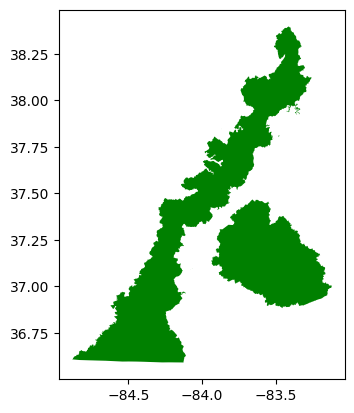

In [17]:
# clean up the dataframe a little bit
cols_to_keep = ['FORESTNAME', 'geometry']
gdf_aoi = gdf_aoi[cols_to_keep]
gdf_aoi.plot(
    color='green'  # you know, for the forest
)

___

## Create a function to clip the tiles to the AOI

In [18]:
#### Create a function to clip the tiles to the AOI
def clip_tiles_to_aoi(gdf_tiles, gdf_aoi):
    # clip the tiles to the AOI
    gdf_tiles_clipped = gpd.clip(gdf_tiles, gdf_aoi)
    return gdf_tiles_clipped

#### Clip the tiles

In [19]:
gdf_tiles_clipped = clip_tiles_to_aoi(gdf_tiles, gdf_aoi)

# print the number of tiles
print(f'The clipped tiles AOI has {gdf_tiles_clipped.shape[0]} tiles.')
gdf_tiles_clipped.head(1)

The clipped tiles AOI has 4035 tiles.


,tilename,key,aws_url,geometry
4537,N197E321,elevation/DEM/Phase2/N197E321_2023_DEM_Phase2_...,https://kyfromabove.s3.us-west-2.amazonaws.com...,"POLYGON ((-84.18753 36.59512, -84.1705 36.5948..."


<Axes: >

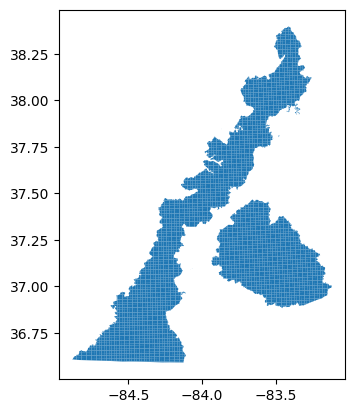

In [20]:
gdf_tiles_clipped.plot()

___
## Download tiles for AOI

Now that we've clipped the tile in our area of interest, now we want to download the files.  Here are some steps:
1. Setup boto3 for no-sign requests.
2. Choose an output location (local drive, your own AWS bucket, etc)
3. Define a function
4. Download

### Set up AWS

The bucket name is `kyfromabove`.  We just need to set that variable once.

When we set up the downloads, we need to use the `key` column from the clipped GeoDataFrame.

*Note: Refer to the Help Documentation to set up [File Transfer Configurations](https://boto3.amazonaws.com/v1/documentation/api/latest/guide/s3.html)*

In [21]:
# set up the AWS Client
s3 = boto3.client('s3', config=Config(signature_version=UNSIGNED))

bucket = 'kyfromabove'

# print the key values 
print(gdf_tiles_clipped['key'].head(3))

4537     elevation/DEM/Phase2/N197E321_2023_DEM_Phase2_...
25013    elevation/DEM/Phase2/N197E320_2023_DEM_Phase2_...
6868     elevation/DEM/Phase2/N197E319_2023_DEM_Phase2_...
Name: key, dtype: object


### Create a function to download files

This will leverage Geopandas *.itertuples():* to iterate through the dataframe download the files.

If you want to be prompted to enter your output folder path, uncomment this the block below.  Otherwise, skip.

In [17]:
# # enter a download path
# download_path = input('enter your output folder path: ')

# print(download_path)

If you just want to enter your path for the variable, use this block below.  Otherwise comment out or skip

In [22]:
# enter a download path
download_path = '../downloads/tiles'  # enter your path in quotations
print(download_path)

../downloads/tiles


This next block sets a creates function to with an optional limit on number of downloads.

In [23]:
# create a function to download the tiles
def download_tiles(s3, bucket, gdf_tiles_clipped, download_path, max_downloads=int):  # Just downloading 5 for my example
    
    """
    Downloads COG or COPC files from an S3 bucket based on the input AOI GeoDataFrame.

    Args:
        s3: The S3 client used to access the bucket.
        bucket: The name of the S3 bucket to download from.
        gdf_tiles_clipped: A GeoDataFrame containing tile information (e.g., bounding boxes).
        download_path: The local directory path where the files should be saved.
        max_downloads: Optional limit on the number of tiles to download.
    
    Returns:
        None
    """
        
    downloaded_files = []  # creating a list of downloaded files
    try:
        for i, row in enumerate(gdf_tiles_clipped.itertuples()):
            if i >= max_downloads:
                break  # stop after max iterations
            
            key = row.key
            # get the base file name of the key
            file_name = key.split('/')[-1]
            local_file_path = os.path.join(download_path, file_name)
            # append to file list
            downloaded_files.append(file_name)
            
            # download file
            if not os.path.exists(local_file_path):  # this will skip downloading duplicates
                s3.download_file(bucket, key, local_file_path)
                print(f'Downloaded {file_name}')
    except Exception as e:
        print(f"Error occurred: {e}")


    return downloaded_files

#### Download files

In [24]:
# download 30 files
download = download_tiles(s3, bucket, gdf_tiles_clipped, download_path, max_downloads=30)

Downloaded N197E321_2023_DEM_Phase2_cog.tif
Downloaded N197E320_2023_DEM_Phase2_cog.tif
Downloaded N197E319_2023_DEM_Phase2_cog.tif
Downloaded N197E318_2023_DEM_Phase2_cog.tif
Downloaded N197E317_2023_DEM_Phase2_cog.tif
Downloaded N196E321_2023_DEM_Phase2_cog.tif
Downloaded N196E320_2023_DEM_Phase2_cog.tif
Downloaded N196E319_2023_DEM_Phase2_cog.tif
Downloaded N196E318_2023_DEM_Phase2_cog.tif
Downloaded N196E317_2023_DEM_Phase2_cog.tif
Downloaded N197E324_2023_DEM_Phase2_cog.tif
Downloaded N197E323_2023_DEM_Phase2_cog.tif
Downloaded N197E322_2023_DEM_Phase2_cog.tif
Downloaded N196E324_2023_DEM_Phase2_cog.tif
Downloaded N196E323_2023_DEM_Phase2_cog.tif
Downloaded N196E322_2023_DEM_Phase2_cog.tif
Downloaded N195E325_2023_DEM_Phase2_cog.tif
Downloaded N195E324_2023_DEM_Phase2_cog.tif
Downloaded N195E323_2023_DEM_Phase2_cog.tif
Downloaded N195E322_2023_DEM_Phase2_cog.tif
Downloaded N194E325_2023_DEM_Phase2_cog.tif
Downloaded N194E324_2023_DEM_Phase2_cog.tif
Downloaded N194E323_2023_DEM_Pha

My test download.<br>
<br><img src='https://raw.githubusercontent.com/ianhorn/kyfromabove-on-aws-examples/refs/heads/main/media/downloaded_tiles.jpg' width="300" height="200">

___
## Create a raster or mosaic dataset in your GIS software of choice.